In [1]:
! pip install torchviz -q
! pip install torch-summary

  Preparing metadata (setup.py) ... done


In [2]:
# namespaces
import copy
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
import plotly.io as pio
pio.renderers.default = 'notebook'
import seaborn as sns
import sklearn
import tensorflow as tf
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import tqdm

# functions
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torchsummary import summary
from tensorflow import keras

In [3]:
# get data, drop index column and zero the blanks
places_df = pd.read_csv('https://raw.githubusercontent.com/markstiles/us-data-analysis/main/places_data.csv')
places_df.drop(places_df.columns[[0]], axis=1, inplace=True)
places_df = places_df.fillna(0)

In [4]:
# build a one-hot by state and attach it
state_dummies = pd.get_dummies(places_df.State_Name)
places_df = pd.concat([places_df, state_dummies.set_axis(places_df.index)], axis=1)

In [5]:
# get rid of the locations and sparse data
drop_cols = [
 'Place_Name', 'State_Abbr', 'State_Name', 'Type', 'All_Employers', 'All_Employees', 'All_Payroll',
 'Agriculture_Employers','Agriculture_Employees','Agriculture_Payroll','Agriculture_Revenue',
 'Construction_Employers','Construction_Employees','Construction_Payroll','Construction_Revenue',
 'Finance_Revenue',
 'Information_Revenue',
 'Management_Employers','Management_Employees','Management_Payroll','Management_Revenue',
 'Manufacturing_Employers','Manufacturing_Employees','Manufacturing_Payroll','Manufacturing_Revenue',
 'Mining_Employers','Mining_Employees','Mining_Payroll','Mining_Revenue',
 'Utilities_Revenue',
 'Wholesale_Employers','Wholesale_Employees','Wholesale_Payroll','Wholesale_Revenue',
 'Consumer_Total_Expense','Consumer_Expense_Alcohol','Consumer_Expense_Alcohol_Home','Consumer_Expense_Beer_Bar','Consumer_Expense_Wine_Bar','Consumer_Expense_Clothes','Consumer_Expense_Mens_Clothes',
 'Consumer_Expense_Womens_Clothes','Consumer_Expense_Childrens_Clothes','Consumer_Expense_Boys_Clothes','Consumer_Expense_Girls_Clothes','Consumer_Expense_Footwear','Consumer_Expense_Dining',
 'Consumer_Expense_Dining_Breakfast','Consumer_Expense_Dining_Lunch','Consumer_Expense_Dining_Dinner','Consumer_Expense_Education','Consumer_Expense_Entertainment','Consumer_Expense_Clubs',
 'Consumer_Expense_Dating','Consumer_Expense_Pet_Food','Consumer_Expense_Pet_Services','Consumer_Expense_Food_Home','Consumer_Expense_Bakery_Home','Consumer_Expense_Dairy_Home','Consumer_Expense_Fruits_Home',
 'Consumer_Expense_Meat_Home','Consumer_Expense_Nonalcohol_Home','Consumer_Expense_Snacks_Home','Consumer_Expense_Healthcare','Consumer_Expense_Mentalcare','Consumer_Expense_Drugcar','Consumer_Expense_House_Services',
 'Consumer_Expense_Eldercare','Consumer_Expense_Landscape','Consumer_Expense_Housekeeping','Consumer_Expense_PC','Consumer_Expense_Housing','Consumer_Expense_Home_Improvements','Consumer_Expense_Energy',
 'Consumer_Expense_Phone','Consumer_Expense_Water','Consumer_Expense_Insurance','Consumer_Expense_Pensions','Consumer_Expense_Personalcare','Consumer_Expense_Haircare','Consumer_Expense_Personalcare_Products',
 'Consumer_Expense_Transport','Consumer_Expense_Gas','Consumer_Expense_Vehicle_Repair','Consumer_Expense_Travel','Consumer_Expense_Airfare','Consumer_Expense_Auto_Rentals','Consumer_Expense_Travel_Lodging',
 'Consumer_Expense_Travel_Meals','Consumer_Expense_Travel_Entertainment',
 'All_Employee_Per_Employer','All_Revenue_Per_Employer','All_Avg_Payroll_Per_Employee','All_Population_Per_Employer',
 'Food_Services_Employee_Per_Employer','Food_Services_Revenue_Per_Employer','Food_Services_Avg_Payroll_Per_Employee','Food_Services_Population_Per_Employer','Waste_Management_Employee_Per_Employer',
 'Waste_Management_Revenue_Per_Employer','Waste_Management_Avg_Payroll_Per_Employee','Waste_Management_Population_Per_Employer','Agriculture_Employee_Per_Employer','Agriculture_Revenue_Per_Employer',
 'Agriculture_Avg_Payroll_Per_Employee','Agriculture_Population_Per_Employer','Arts_Employee_Per_Employer','Arts_Revenue_Per_Employer','Arts_Avg_Payroll_Per_Employee','Arts_Population_Per_Employer',
 'Construction_Employee_Per_Employer','Construction_Revenue_Per_Employer','Construction_Avg_Payroll_Per_Employee','Construction_Population_Per_Employer','Education_Employee_Per_Employer',
 'Education_Revenue_Per_Employer','Education_Avg_Payroll_Per_Employee','Education_Population_Per_Employer','Finance_Employee_Per_Employer','Finance_Revenue_Per_Employer','Finance_Avg_Payroll_Per_Employee',
 'Finance_Population_Per_Employer','Healthcare_Employee_Per_Employer','Healthcare_Revenue_Per_Employer','Healthcare_Avg_Payroll_Per_Employee','Healthcare_Population_Per_Employer','Information_Employee_Per_Employer',
 'Information_Revenue_Per_Employer','Information_Avg_Payroll_Per_Employee','Information_Population_Per_Employer','Management_Employee_Per_Employer','Management_Revenue_Per_Employer','Management_Avg_Payroll_Per_Employee',
 'Management_Population_Per_Employer','Manufacturing_Employee_Per_Employer','Manufacturing_Revenue_Per_Employer','Manufacturing_Avg_Payroll_Per_Employee','Manufacturing_Population_Per_Employer','Mining_Employee_Per_Employer',
 'Mining_Revenue_Per_Employer','Mining_Avg_Payroll_Per_Employee','Mining_Population_Per_Employer','Other_Employee_Per_Employer','Other_Revenue_Per_Employer','Other_Avg_Payroll_Per_Employee','Other_Population_Per_Employer',
 'Technical_Employee_Per_Employer','Technical_Revenue_Per_Employer','Technical_Avg_Payroll_Per_Employee','Technical_Population_Per_Employer','Real_Estate_Employee_Per_Employer','Real_Estate_Revenue_Per_Employer',
 'Real_Estate_Avg_Payroll_Per_Employee','Real_Estate_Population_Per_Employer','Retail_Employee_Per_Employer','Retail_Revenue_Per_Employer','Retail_Avg_Payroll_Per_Employee','Retail_Population_Per_Employer',
 'Transportation_Employee_Per_Employer','Transportation_Revenue_Per_Employer','Transportation_Avg_Payroll_Per_Employee','Transportation_Population_Per_Employer','Utilities_Employee_Per_Employer','Utilities_Revenue_Per_Employer',
 'Utilities_Avg_Payroll_Per_Employee','Utilities_Population_Per_Employer','Wholesale_Employee_Per_Employer','Wholesale_Revenue_Per_Employer','Wholesale_Avg_Payroll_Per_Employee','Wholesale_Population_Per_Employer',
 'Income_Per_Revenue',
 'Revenue_Per_Person','Profit_Per_Person',
 'Population_Range', 'Performance'
]
places_df.drop(columns=drop_cols, inplace=True)

In [6]:
# drop the top skewing outliers
places_df = places_df[places_df.All_Revenue < 20000000]

In [7]:
# set the y to revenue
y = places_df['All_Revenue'].to_numpy()
# remove the identifier and target columns
x = places_df.drop(columns=['GeoId', 'All_Revenue'])
x.shape

(9720, 174)

In [8]:
# normalize
scaler = MinMaxScaler()
scaler.fit(x)
fit_data = scaler.transform(x)

In [9]:
# train-test split for model evaluation
x_train, x_test, y_train, y_test = train_test_split(fit_data, y, train_size=0.7, shuffle=True)

# convert to 2d pytorch tensors
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

In [10]:
# define the model
model = nn.Sequential(
    nn.Linear(x.shape[1], 384),
    nn.ReLU(),
    nn.Linear(384, 32),
    nn.ReLU(),
    nn.Linear(32, 32),
    nn.ReLU(),
    nn.Linear(32, 1)
)

# set the weights for the regression model
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

model.apply(init_weights)

# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.001)

# hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
train_history = []
test_history = []

In [11]:
n_epochs = 1000   # number of epochs to run
batch_size = 200  # size of each batch
batch_start = torch.arange(0, len(x_train), batch_size)
step_count = 0
step_size = 100

In [12]:
# train and store progress
for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=False) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            x_batch = x_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]

            optimizer.zero_grad()

            # forward pass
            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch)
            mse = float(loss)
            if mse < best_mse:
              best_mse = mse
              best_weights = copy.deepcopy(model.state_dict())

            if step_count % step_size == 0:
              train_history.append(loss.item())
              with torch.no_grad():
                  y_test_pred = model(x_test)
                  test_loss = loss_fn(y_test_pred.float(), y_test)
                  test_history.append(test_loss.item())

            # backward pass
            loss.backward()

            # update weights
            optimizer.step()

            # print progress
            bar.set_postfix(mse=float(loss))

            step_count += 1

Epoch 999: 100%|██████████| 35/35 [00:00<00:00, 72.53batch/s, mse=4.91e+5]


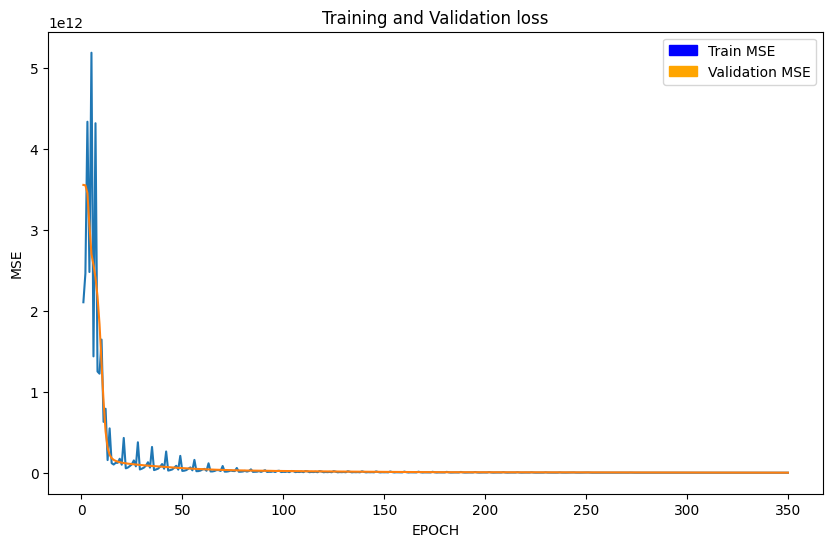

In [13]:
blue_patch = mpatches.Patch(color = 'blue', label = 'Train MSE')
orange_patch = mpatches.Patch(color = 'orange', label = 'Validation MSE')

plt.figure(figsize=(10,6))

sns.lineplot(x=range(1,len(train_history)+1),y = train_history)
sns.lineplot(x=range(1,len(test_history)+1),y = test_history)

plt.xlabel('EPOCH')
plt.ylabel('MSE')
plt.legend(handles = [blue_patch,orange_patch])
plt.title('Training and Validation loss');

In [14]:
# restore model and return best accuracy
model.load_state_dict(best_weights)

<All keys matched successfully>

In [15]:
# give it a test on my hometown
waltham = places_df[places_df.GeoId==2572600]
actual = waltham.iloc[0].All_Revenue
waltham_scaled = scaler.transform(waltham.drop(columns=['GeoId', 'All_Revenue']))
prediction = model(torch.tensor(waltham_scaled, dtype=torch.float32)).item()
print(f'actual: {int(actual):,}')
print(f'predicted: {int(prediction):,}')
diff = int(abs(prediction-actual))
print(f'difference: {diff:,}')
percent_diff = int((diff/actual)*100)
print(f'percent difference: {percent_diff:,}')

actual: 7,967,909
predicted: 7,974,816
difference: 6,907
percent difference: 0
